In [1]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network
from graphviz import Digraph
import plotly.express as px

# Graph Creation
import ast
import networkx as nx
from py2cfg import CFGBuilder
import tree_sitter_python as tspython
from tree_sitter import Language, Parser

PY_LANGUAGE = Language(tspython.language())
parser = Parser(PY_LANGUAGE)

# Torch
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, HeteroData, Data
from torch_geometric.nn import HeteroConv, GCNConv, GATv2Conv, global_mean_pool

# NLP
from transformers import RobertaTokenizer, RobertaModel
import optuna
import torch

# Text embedding
from sentence_transformers import SentenceTransformer

# sklearn
from sklearn.decomposition import PCA

# Other
import copy, uuid, json, re
import warnings, sys, os, random
from tqdm import tqdm
import dash
from dash import html
import dash_cytoscape as cyto

# SETTINGS
pd.set_option('display.max_columns', 70)
warnings.filterwarnings("ignore")

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Own version

---
Call Graph

In [2]:
class CallGraph:

    imports = None
    classes = None
    functions = None
    calls = None

    nodes = None
    edges = None

    imp_id = 0
    cls_id = 0
    fnc_id = 0
    cll_id = 0


    def __init__(self):
        self.imports = pd.DataFrame(columns=['file_id', 'imp_id', 'name', 'from', 'as_name'])
        self.classes = pd.DataFrame(columns=['file_id', 'cls_id', 'name', 'base_classes'])
        self.functions = pd.DataFrame(columns=['file_id', 'fnc_id', 'name', 'class', 'class_base_classes', 'params'])
        self.calls = pd.DataFrame(columns=['file_id', 'cll_id', 'name', 'class', 'class_base_classes'])


    # Return type can be :
    #   - "pandas": for pandas DataFrames 
    #   - "original" for original pandas dataframes (imports, classes, functions, calls)
    #   - "networkx" for a NetworkX graph
    #   - "pytorch" for a PyTorch Geometric graph
    def build_call_graph(self, path, return_type="pandas", repo_functions_only=True):
        """
        Build a call graph from the given file path.
        Parameters:
            - path (str): The path to the directory containing Python files.
            - return_type (str): The type of the return value. Can be "pandas", "original", "networkx", or "pytorch".
            - repo_functions_only (bool): If True, only consider function calls within the repository.
        """

        # Reset IDs
        self.imp_id = 0
        self.cls_id = 0
        self.fnc_id = 0
        self.cll_id = 0


        for dirpath, _, filenames in os.walk(path):
            for filename in filenames:
                if filename.endswith(".py"):
                    
                    file_id = str(uuid.uuid1())

                    file_path = os.path.join(dirpath, filename)
                    python_code = ''
                    with open(file_path, 'r', encoding='utf-8') as f:
                        python_code += f.read()

                    tree = ast.parse(python_code)
                    self.process_file_ast(tree, return_dataframes=False, file_id=file_id)

        split_columns = self.calls['name'].str.split('.', n=1, expand=True)

        # Add combined name column to functions dataframe
        self.functions['combinedName'] = self.functions.apply(
            lambda x: (
                x["name"] if x["class"] == 'Global' else
                str(x["class"]) + '.' + str(x['name'])
            ), axis=1
        )

        # Columns to store the split results
        self.calls['call_object'] = split_columns[0]
        self.calls['call_functiondot'] = split_columns[1]  # Automatically None if no dot is present

        # Resolve caller object
        self._resolve_caller_object()

        # Calls resolved combined name
        self.calls['combinedName'] = self.calls.apply(
            lambda x: (
                str(x["resolved_call_object"]) if x["call_functiondot"] is None else
                str(x["resolved_call_object"]) + '.' + str(x['call_functiondot'])
            ), axis=1
        )

        if return_type == "original":
            return self.imports, self.classes, self.functions, self.calls

        # Create nodes and edges for the call graph
        self.nodes = copy.deepcopy(self.functions)
        self.edges = copy.deepcopy(self.calls.loc[self.calls['func_id'].notnull()])

        # If we only want to consider function calls within the repository
        if repo_functions_only:
            self.edges = self.edges.merge(self.nodes[['fnc_id', 'combinedName']], left_on='combinedName', right_on='combinedName', how='inner')[['func_id', 'fnc_id']] \
                .rename(columns={'func_id': 'source_id', 'fnc_id': 'target_id'})
        
        # If we want to consider all function calls, including those not defined in the repository (e.g., external libraries)
        else:
            # Merge edges with nodes to find undefined functions
            self.edges = self.edges.merge(self.nodes[['fnc_id', 'combinedName']], left_on='combinedName', right_on='combinedName', how='left')

            # Identify new nodes that are not in the existing nodes and create dataframe for them
            new_nodes = self.edges.loc[self.edges['fnc_id'].isnull()].drop_duplicates(subset=['combinedName'])
            new_nodes['new_fnc_id'] = range(self.fnc_id, self.fnc_id + len(new_nodes))
            new_nodes = new_nodes[['new_fnc_id', 'combinedName']].rename(columns={'new_fnc_id': 'fnc_id'})
            new_nodes['file_id'] = None
            new_nodes['name'] = new_nodes['combinedName']
            new_nodes['docstring'] = None
            new_nodes['class_id'] = None
            new_nodes['class'] = None
            new_nodes['class_base_classes'] = '[]'
            new_nodes['params'] = '{}'
            new_nodes = new_nodes[['file_id', 'fnc_id', 'name', 'class', 'class_base_classes', 'params', 'docstring', 'class_id', 'combinedName']]
            
            # Update the function ID counter
            self.fnc_id += len(new_nodes)

            # Concatenate the new nodes with the existing nodes
            self.nodes = pd.concat([self.nodes, new_nodes], ignore_index=True).reset_index(drop=True)

            # Update the edges with the new function IDs
            self.edges = self.edges.merge(new_nodes[['fnc_id', 'combinedName']].rename(columns={'fnc_id': 'new_fnc_id'}), on='combinedName', how='left')
            self.edges['fnc_id'] = self.edges['fnc_id'].fillna(self.edges['new_fnc_id'])
            self.edges = self.edges.drop(columns=['new_fnc_id'])
            self.edges = self.edges.rename(columns={'func_id': 'source_id', 'fnc_id': 'target_id'})[['source_id', 'target_id']]
            self.edges['target_id'] = self.edges['target_id'].astype(int)

        if return_type == "pandas":
            return self.nodes, self.edges
        
        elif return_type == "networkx":
            G = nx.from_pandas_edgelist(self.edges, source='source_id', target='target_id', create_using=nx.DiGraph())
            for _, row in self.nodes.iterrows():
                G.nodes[row['fnc_id']].update({
                    'file_id': row['file_id'],
                    'name': row['name'],
                    'class': row['class'],
                    'class_base_classes': row['class_base_classes'],
                    'params': row['params'],
                    'docstring': row['docstring']
                })
            return G
        
        else:
            x = torch.tensor(self.nodes['fnc_id'].values, dtype=torch.long)
            edge_index = torch.tensor(self.edges.values.T, dtype=torch.long)
            data = Data(x=x, edge_index=edge_index)
            return data
        


    def process_file_ast(self, ast_tree, return_dataframes=True, file_id=None):
        """
        Create a call graph from the given AST tree.
        """

        self._walk_ast(ast_tree, file_id=file_id)
        
        # Reset IDs for next use
        # self.imp_id = 0
        # self.cls_id = 0
        # self.fnc_id = 0
        # self.cll_id = 0

        if return_dataframes:
            return self.imports, self.classes, self.functions, self.calls



    def visualize_graph(self, output_path='graph.html'):
        # Create graph
        G = nx.Graph()

        # Add nodes
        for _, row in self.nodes.iterrows():
            node_id = str(row['fnc_id'])
            node_label = str(row['combinedName'])
            #node_docstring = str(row['docstring_embedding'])
            #node_label += f"\n {node_docstring}" if node_docstring else ''
            G.add_node(node_id, label=node_label)

        # Add edges
        for _, row in self.edges.iterrows():
            source = str(row['source_id'])
            target = str(row['target_id'])
            if source in G.nodes and target in G.nodes:
                G.add_edge(source, target)

        # Pyvis graph
        net = Network(height='1700px', width='100%', notebook=False)
        net.from_nx(G)
        net.force_atlas_2based()

        # Save
        net.save_graph(output_path)



    def _walk_ast(self, node, file_id=None, class_id=None, class_name=None, base_classes=None, func_id=None, func_name=None, func_params=None):

        # Handle Imports
        self._handle_imports(node, file_id=file_id)

        # Class definitions
        node_class_id, node_class_name, node_base_classes = self._handle_class_definitions(node=node, file_id=file_id)
        if node_class_id is not None:
            class_id = node_class_id
            class_name = node_class_name
            base_classes = node_base_classes
        
        # Function definitions
        node_func_id, node_func_name, node_func_params = self._handle_functions(
            node=node, 
            file_id=file_id, 
            class_id=class_id, 
            class_name=class_name, 
            base_classes=base_classes
        )
        if node_func_id is not None:
            func_id = node_func_id
            func_name = node_func_name
            func_params = node_func_params

        # Call expressions
        self._handle_call_expressions(
            node=node, 
            file_id=file_id,
            class_id=class_id, 
            class_name=class_name, 
            base_classes=base_classes, 
            func_id=func_id, 
            func_name=func_name, 
            func_params=func_params
        )

        for child in ast.iter_child_nodes(node):
            self._walk_ast(
                node=child, 
                file_id=file_id,
                class_id=class_id, 
                class_name=class_name, 
                base_classes=base_classes, 
                func_id=func_id, 
                func_name=func_name, 
                func_params=func_params
            )



    def _handle_imports(self, node, file_id=None):
        if isinstance(node, ast.Import):
            for alias in node.names:
                if alias.asname:
                    if file_id:
                        new_row = pd.DataFrame([{'file_id': file_id, 'imp_id': self.imp_id, 'name': alias.name, 'from': None, 'as_name': alias.asname}])
                    else:
                        new_row = pd.DataFrame([{'imp_id': self.imp_id, 'name': alias.name, 'from': None, 'as_name': alias.asname}])
                    self.imports = pd.concat([self.imports, new_row], ignore_index=True).reset_index(drop=True)
                    self.imp_id += 1
                else:
                    if file_id:
                        new_row = pd.DataFrame([{'file_id': file_id, 'imp_id': self.imp_id, 'name': alias.name, 'from': None, 'as_name': alias.name}])
                    else:
                        new_row = pd.DataFrame([{'imp_id': self.imp_id, 'name': alias.name, 'from': None, 'as_name': alias.name}])
                    self.imports = pd.concat([self.imports, new_row], ignore_index=True).reset_index(drop=True)
                    self.imp_id += 1
        elif isinstance(node, ast.ImportFrom):
            for alias in node.names:
                if alias.asname:
                    if file_id:
                        new_row = pd.DataFrame([{'file_id': file_id, 'imp_id': self.imp_id, 'name': alias.name, 'from': node.module, 'as_name': alias.asname}])
                    else:
                        new_row = pd.DataFrame([{'imp_id': self.imp_id, 'name': alias.name, 'from': node.module, 'as_name': alias.asname}])
                    self.imports = pd.concat([self.imports, new_row], ignore_index=True).reset_index(drop=True)
                    self.imp_id += 1
                else:
                    if file_id:
                        new_row = pd.DataFrame([{'file_id': file_id, 'imp_id': self.imp_id, 'name': alias.name, 'from': node.module, 'as_name': alias.name}])
                    else:
                        new_row = pd.DataFrame([{'imp_id': self.imp_id, 'name': alias.name, 'from': node.module, 'as_name': alias.name}])
                    self.imports = pd.concat([self.imports, new_row], ignore_index=True).reset_index(drop=True)
                    self.imp_id += 1



    def _handle_class_definitions(self, node, file_id=None):
        if isinstance(node, ast.ClassDef):
            node_class_id = self.cls_id
            node_class_name = node.name
            node_base_classes = [ast.unparse(base) for base in node.bases] if node.bases else []
            if file_id:
                new_row = pd.DataFrame([{'file_id': file_id, 'cls_id': node_class_id, 'name': node_class_name, 'docstring': ast.get_docstring(node),  'base_classes': node_base_classes}])
            else:
                new_row = pd.DataFrame([{'cls_id': node_class_id, 'name': node_class_name, 'docstring': ast.get_docstring(node),  'base_classes': node_base_classes}])
            self.classes = pd.concat([self.classes, new_row], ignore_index=True).reset_index(drop=True)
            self.cls_id += 1
            return node_class_id, node_class_name, node_base_classes
        else:
            return None, None, None
        


    def _handle_functions(self, node, file_id=None, class_id=None, class_name=None, base_classes=None):
        if isinstance(node, ast.FunctionDef):
            func_id = self.fnc_id
            func_name = node.name
            class_name = class_name if class_name else 'Global'
            base_classes = base_classes if base_classes else []

            param_types = {}
            for arg in node.args.args:
                if arg.annotation:
                    param_types[arg.arg] = ast.unparse(arg.annotation)
                else:
                    param_types[arg.arg] = 'Any'

            if file_id:
                new_row = pd.DataFrame([{
                    'file_id': file_id,
                    'fnc_id': func_id,
                    'name': func_name,
                    'docstring': ast.get_docstring(node),
                    'function_code': ast.unparse(node),
                    'class_id': class_id if class_id is not None else None,
                    'class': class_name,
                    'class_base_classes': base_classes,
                    'params': json.dumps(param_types)
                }])
            else:
                new_row = pd.DataFrame([{
                    'fnc_id': func_id,
                    'name': func_name,
                    'docstring': ast.get_docstring(node),
                    'function_code': ast.unparse(node),
                    'class_id': class_id if class_id is not None else None,
                    'class': class_name,
                    'class_base_classes': base_classes,
                    'params': json.dumps(param_types)
                }])
            self.functions = pd.concat([self.functions, new_row], ignore_index=True).reset_index(drop=True)
            self.fnc_id += 1

            return func_id, func_name, param_types
        else:
            return None, None, None
            
        

    def _handle_call_expressions(self, node, file_id=None, class_id=None, class_name=None, base_classes=None, func_id=None, func_name=None, func_params=None):
        if isinstance(node, ast.Call):
            call = ast.unparse(node.func)
            class_name = class_name if class_name else 'Global'
            base_classes = base_classes if base_classes else []
            if file_id:
                new_row = pd.DataFrame([{
                    'file_id': file_id,
                    'cll_id': self.cll_id,
                    'name': call,
                    'class_id': class_id if class_id is not None else None,
                    'class': class_name,
                    'class_base_classes': base_classes,
                    'func_id': func_id if func_id is not None else None,
                    'func_name': func_name if func_name is not None else None,
                    'func_params': func_params
                }])
            else:
                new_row = pd.DataFrame([{
                    'cll_id': self.cll_id,
                    'name': call,
                    'class_id': class_id if class_id is not None else None,
                    'class': class_name,
                    'class_base_classes': base_classes,
                    'func_id': func_id if func_id is not None else None,
                    'func_name': func_name if func_name is not None else None,
                    'func_params': func_params
                }])
            self.calls = pd.concat([self.calls, new_row], ignore_index=True).reset_index(drop=True)
            self.cll_id += 1



    def _resolve_caller_object(self):

        # Create a lookup table for the imports
        import_alias_map = {
            (row['file_id'], row['as_name']): row['name']
            for _, row in self.imports.dropna(subset=['as_name']).iterrows()
        }

        # Handle self and super calls
        self.calls['resolved_call_object'] = self.calls.apply(
            lambda x: (
                # Handle 'self' calls
                x["class"] if x["call_object"] == 'self' and pd.notnull(x["call_functiondot"]) else
                # Handle 'super' calls
                x["class_base_classes"][0] if isinstance(x["call_object"], str) and 'super' in x["call_object"] and pd.notnull(x["call_functiondot"]) and len(x["class_base_classes"]) > 0 else
                # Handle function parameters
                x["func_params"].get(x["call_object"], x["call_object"]) if isinstance(x["func_params"], dict) and x["call_object"] in x["func_params"] else
                # Handle imports - if no import alias is found, use the original call object
                import_alias_map.get((x["file_id"], x["call_object"]), x["call_object"])
            ), axis=1
        )

In [3]:
cg_nodes, cg_edges = CallGraph().build_call_graph("./repos/Python/manim/manim/")

In [4]:
cg_nodes.head(3)

,file_id,fnc_id,name,class,class_base_classes,params,docstring,function_code,class_id,combinedName
0,b8068d0a-51d3-11f0-b73f-581cf8fd201d,0,show_splash,Global,[],"{""ctx"": ""click.Context"", ""param"": ""click.Optio...","When giving a value by console, show an initia...","def show_splash(ctx: click.Context, param: cli...",None,show_splash
1,b8068d0a-51d3-11f0-b73f-581cf8fd201d,1,print_version_and_exit,Global,[],"{""ctx"": ""click.Context"", ""param"": ""click.Optio...","Same as :func:`show_splash`, but also exit whe...","def print_version_and_exit(ctx: click.Context,...",None,print_version_and_exit
2,b8068d0a-51d3-11f0-b73f-581cf8fd201d,2,main,Global,[],"{""ctx"": ""click.Context""}",The entry point for Manim.\n\nParameters\n----...,@cloup.group(context_settings=cli_ctx_settings...,None,main


---
Subgraph (AST, CFG)

In [6]:
class FunctionGraphBuilder():

    node_id = 0
    cfg = None

    def __init__(self):
        self.nodes = pd.DataFrame(columns=['node_id', 'name', 'code', 'parent_id'])
        self.edges = pd.DataFrame(columns=['source_id', 'target_id'])


    def create_graph(self, code, graph_type="AST", package='ts', edge_set='default', visualize=False):
        """
        Parse the given code and return the AST.
        Parameters:
            - code (str): The Python code to parse.
            - graph_type (str): The type of graph to create. Can be "AST" or "CFG".
            - package (str): The package to use for parsing. Can be 'ts' for tree-sitter or 'ast' for python ast.
            - edge_set (str): The type of edges to create. Can be 'default' or 'extended'. Only applicable for AST.
        """
        
        cleaned_code = self._remove_docstring(code)

        # -------------------------------------
        # Create AST
        if graph_type in ["AST", "ast"]:

            if package == 'ts':
                tree = parser.parse(bytes(cleaned_code, "utf8"))
                self._TS_create_ast(tree, source_code=bytes(cleaned_code, "utf8"))
            else:
                tree = ast.parse(cleaned_code)
                self._AST_create_ast(tree, parent_id=None)
            
            self.edges = self.nodes[['parent_id', 'node_id']].rename(columns={'parent_id': 'source_id', 'node_id': 'target_id'}).dropna()

            if edge_set == 'extended':

                # Connect leaf consecutive leaf nodes
                leaf_nodes = self.nodes[self.nodes['is_leaf']]
                leaf_nodes['target_id'] = leaf_nodes['node_id'].shift(-1)
                leaf_nodes = leaf_nodes.dropna(subset=['target_id'])
                leaf_edges = leaf_nodes[['node_id', 'target_id']].rename(columns={'node_id': 'source_id', 'target_id': 'target_id'})
                self.edges = pd.concat([self.edges, leaf_edges], ignore_index=True).reset_index(drop=True)
        
        # -------------------------------------
        # Create Control Flow Graph (CFG)
        elif graph_type in ["CFG", "cfg"]:

            try:
                self._CFG_create_cfg(cleaned_code)
                if visualize:
                    self.cfg.build_visual("cfg_output", format='png')
            except:
                print("Error creating CFG. Returning empty DataFrames.")
                return pd.DataFrame(columns=['node_id', 'code', 'parent_id']), pd.DataFrame(columns=['source_id', 'target_id'])

        return self.nodes, self.edges
    

    def _remove_docstring(self, code):
        """
        Remove docstrings from the code.
        """
        tree = ast.parse(code)

        # Remove docstrings from the AST
        for node in ast.walk(tree):
            if isinstance(node, ast.FunctionDef):
                if len(node.body) > 1:
                    node.body = node.body[1:]
        
        return ast.unparse(tree)

    def _AST_create_ast(self, node, parent_id=None):

        node_id = self.node_id
        node_name = type(node).__name__
        if node_name == 'Load' or node_name == 'Store':
            return
        
        node_code = ast.unparse(node) if hasattr(ast, 'unparse') else str(node)

        new_row = pd.DataFrame([{
            'node_id': node_id,
            'name': node_name,
            'code': node_code,
            'parent_id': parent_id,
            'is_leaf': len(list(ast.iter_child_nodes(node))) == 0
        }])
        
        self.nodes = pd.concat([self.nodes, new_row], ignore_index=True).reset_index(drop=True)
        self.node_id += 1

        for child in ast.iter_child_nodes(node):
            self._create_ast(child, parent_id=node_id)

    def _TS_create_ast(self, tree, source_code):

        nodes = []
        node_id_counter = [0]

        def traverse(node, parent_id):
            current_id = node_id_counter[0]
            node_id_counter[0] += 1

            node_type = node.type
            code_snippet = source_code[node.start_byte:node.end_byte].decode("utf8")

            nodes.append({
                "node_id": current_id,
                "name": node_type,
                "code": code_snippet,
                "parent_id": parent_id,
                "is_leaf": len(node.children) == 0
            })

            for child in node.children:
                traverse(child, current_id)

        root_node = tree.root_node
        traverse(root_node, parent_id=None)

        self.nodes = pd.DataFrame(nodes)

    def _CFG_create_cfg(self, code):
        """
        Create a control flow graph (CFG) from the given code.
        """

        self.cfg = CFGBuilder().build_from_src("example", code)
        self.cfg.build_visual("cfg_output", format='json')
        
        with open("cfg_output.json") as f:
            data = json.load(f)

        # Csak azok a node-ok, amik "_ldraw_" alatt szöveget (text) tartalmaznak
        nodes = []
        for obj in data["objects"]:
            if "_ldraw_" in obj:
                text_parts = [entry["text"] for entry in obj["_ldraw_"] if entry["op"] == "T"]
                if text_parts:
                    nodes.append({
                        "node_id": int(obj["_gvid"]),
                        "code": "\\n".join(text_parts)
                    })

        self.nodes = pd.DataFrame(nodes)

        edges = []
        for edge in data["edges"]:
            source = edge["tail"]
            target = edge["head"]
            label = ""
            for item in edge.get("_ldraw_", []):
                if item["op"] == "T":
                    label = item["text"]
            edges.append({
                "source_id": source,
                "target_id": target,
                "label": label
            })

        self.edges = pd.DataFrame(edges)

        # Drop the isolated nodes
        self.nodes = self.nodes[self.nodes['node_id'].isin(self.edges['source_id']) | self.nodes['node_id'].isin(self.edges['target_id'])].reset_index(drop=True)
        self.nodes = self.nodes.iloc[:-8] # Remove the last 8 nodes, which are added by the package for plotting a legend to the visual output

In [11]:
cg_nodes['function_code_wout_docstring'] = cg_nodes['function_code'].apply(lambda x: FunctionGraphBuilder()._remove_docstring(x))
longest_idx = cg_nodes['function_code_wout_docstring'].str.len().idxmax()
code = cg_nodes.loc[100]['function_code_wout_docstring']
# code = cg_nodes.loc[longest_idx]['function_code_wout_docstring']
code

'def update_submobject_list(self, index: int) -> None:\n    for mobj in current_submobjects[:-1]:\n        mobj.set_opacity(0)\n    if len(current_submobjects) > 0:\n        current_submobjects[-1].set_opacity(1)'

In [18]:
nodes, edges = FunctionGraphBuilder().create_graph(code, graph_type="cfg", visualize=True)
nodes


(process:3680): Pango-WARNING **: 19:24:48.402: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.

(process:9348): Pango-WARNING **: 19:24:48.809: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.


,node_id,code
0,5,if len(current_submobjects) > 0:
1,6,len
2,7,current_submobjects[-1].set_opacity(1)
3,8,current_submobjects.set_opacity


---
CFG

In [64]:
code = """
def __init__(self, *mobjects: Mobject, shift: np.ndarray | None=None, target_position: np.ndarray | Mobject | None=None, scale: float=1, **kwargs) -> None:
    mobject = mobjects[0] if len(mobjects) == 1 else Group(*mobjects)
    self.point_target = False
    if isinstance(target_position, (Mobject, OpenGLMobject)):
        target_position = target_position.get_center()
    elif shift is None:
        if target_position is not None:
            print("Intermed_Test")
        else:
            print("Other_intermed_Test")

    else:
        print("Test_2")


    i = 0

    while i < 10:
        print("while_test")
        i += 1
        if i == 5:
            if target_position is not None:
                print("valami test")
            elif target_position is not None:
                print("if_elif_in_while_test")
            else:
                print("hello")
        print("while_test2")
        

    try:
        try:
            for mobject in mobjects:
                print("for_test")
        finally:
            print("test3")
    finally:
        print("test4")
"""

code_2 = """
def __init__(self, *mobjects: Mobject, shift: np.ndarray | None=None, target_position: np.ndarray | Mobject | None=None, scale: float=1, **kwargs) -> None:
    mobject = mobjects[0] if len(mobjects) == 1 else Group(*mobjects)
    self.point_target = False
    if shift is None:
        if target_position is not None:
            if isinstance(target_position, (Mobject, OpenGLMobject)):
                target_position = target_position.get_center()
            else:
                print("Test_2")
            shift = target_position - mobject.get_center()
            self.point_target = True
        else:
            shift = ORIGIN
    self.shift_vector = shift
  
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=DeprecationWarning)
    for mobject in mobjects:
        if target_position is not None:
            if isinstance(target_position, (Mobject, OpenGLMobject)):
                continue
            try:
                print("Kód a try blokkban")
                x = 1 / 0  # Ez kivételt dob (ZeroDivisionError)
            except ZeroDivisionError:
                print("Hiba: osztás nullával")
            finally:
                print("Ez mindig lefut")
        return False
      
    super().__init__(mobject, **kwargs)
    
"""

In [ ]:
class ControlFlowGraph():

    special_node_types = [
        'if_statement', 'elif_clause', 'else_clause', 'for_statement', 
        'while_statement', 'with_statement', 'continue_statement', 
        'break_statement', 'return_statement', 'raise_statement', 
        'try_statement', 'except_clause', 'finally_clause'
    ]

    node_id = 0
    nodes = []

    row_node_id = 0
    row_nodes = []

    edges = []
    break_edges = []
    continue_edges = []

    def __init__(self):
        self.node_id = 0
        self.nodes = []
        self.row_node_id = 0
        self.row_nodes = []
        self.edges = []
        self.break_edges = []
        self.continue_edges = []

    def build_cfg(self, code):
        """
        Build a control flow graph from the given code.
        Parameters:
            - code (str): The Python code to parse.
        """
        tree = Parser(Language(tspython.language())).parse(bytes(code, "utf8"))

        self._traverse(tree.root_node)
        row_nodes_df = pd.DataFrame(self.row_nodes)

        # Group row nodes by depth and type, add id to final nodes
        row_nodes_df = self._create_cfg_nodes(row_nodes_df)


        # Create the final nodes DataFrame
        self.nodes = row_nodes_df.drop(columns=['row_node_id']).groupby("node_id").agg({
            "depth": "first",
            "type": "first",
            "code": lambda x: "\n".join(x),
            "condition": "first",
            "is_leaf": "last"
        }).reset_index()

        # Create the edges
        self._create_cfg_edges()

        # Remove unnecessary nodes
        self._remove_unnecessary_nodes()

        # Rmove duplicate edges
        self._remove_unnecessary_edges()

        return self.nodes, self.edges
    


    def print_ast(self, code):
        """
        Print the AST of the given code.
        Parameters:
            - code (str): The Python code to parse.
        """
        tree = Parser(Language(tspython.language())).parse(bytes(code, "utf8"))
        self._ast_traverse(tree.root_node)

    

    def _traverse(self, node, depth=0):

        # Simple expression statements
        if node.type == 'expression_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8"),
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1

        # ---------------------------------------
        #             IF Statements
        # ---------------------------------------

        # If statements
        elif node.type == 'if_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': node.child_by_field_name('condition').text.decode("utf8") if node.child_by_field_name('condition') else None,
                'is_leaf': False
            })
            self.row_node_id += 1
            depth += 1

        # Elif statements
        elif node.type == 'elif_clause':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth - 1,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': node.child_by_field_name('condition').text.decode("utf8") if node.child_by_field_name('condition') else None,
                'is_leaf': False
            })
            self.row_node_id += 1

        # Else statements
        elif node.type == 'else_clause':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth - 1,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': None,
                'is_leaf': False
            })
            parent_id = self.row_node_id
            self.row_node_id += 1


        # ---------------------------------------
        #             FOR Statements
        # ---------------------------------------

        # For statements
        elif node.type == 'for_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': node.child_by_field_name('condition').text.decode("utf8") if node.child_by_field_name('condition') else None,
                'is_leaf': False
            })
            self.row_node_id += 1
            depth += 1


        # ---------------------------------------
        #            WHILE Statements
        # ---------------------------------------

        # While statements
        elif node.type == 'while_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': node.child_by_field_name('condition').text.decode("utf8") if node.child_by_field_name('condition') else None,
                'is_leaf': False
            })
            self.row_node_id += 1
            depth += 1


        # ---------------------------------------
        #             WITH Statements
        # ---------------------------------------

        # With statements
        elif node.type == 'with_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1
            depth += 1

        # ---------------------------------------
        #             CONTINUE Statement
        # ---------------------------------------

        # Continue statements
        elif node.type == 'continue_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8"),
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1

        
        # ---------------------------------------
        #             BREAK Statement
        # ---------------------------------------

        # Break statements
        elif node.type == 'break_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8"),
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1
        

        # ---------------------------------------
        #             RETURN Statement
        # ---------------------------------------

        # Return statements
        elif node.type == 'return_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8"),
                'condition': None,
                'is_leaf': True
            })
            self.row_node_id += 1


        # ---------------------------------------
        #            RAISE Statement
        # ---------------------------------------

        # Raise statements
        elif node.type == 'raise_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8"),
                'condition': None,
                'is_leaf': True
            })
            self.row_node_id += 1


        # ---------------------------------------
        #            TRY Statement
        # ---------------------------------------

        elif node.type == 'try_statement':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1
            depth += 1


        # ---------------------------------------
        #            EXCEPT Statement
        # ---------------------------------------

        elif node.type == 'except_clause':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth - 1,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1

        
        # ---------------------------------------
        #            FINALLY Statement
        # ---------------------------------------

        elif node.type == 'finally_clause':
            self.row_nodes.append({
                'row_node_id': self.row_node_id,
                'depth': depth - 1,
                'type': node.type,
                'code': node.text.decode("utf8").split('\n')[0],
                'condition': None,
                'is_leaf': False
            })
            self.row_node_id += 1


        for child in node.children:
            self._traverse(child, depth=depth)

    def _create_cfg_nodes(self, row_nodes_df):
        row_nodes_df['node_id'] = 0
        for i, row in row_nodes_df.iterrows():
            if row['type'] in self.special_node_types or row_nodes_df.iloc[i - 1]['depth'] != row['depth']:
                self.node_id += 1
                row_nodes_df.at[i, 'node_id'] = self.node_id
            else:
                row_nodes_df.at[i, 'node_id'] = self.node_id

        return row_nodes_df

    def _create_cfg_edges(self):

        for idx, row in self.nodes.iterrows():

            next_row = self.nodes.iloc[idx + 1] if idx + 1 < len(self.nodes) else None

            # Create an edge between the current node and the next node
            if next_row is not None and \
               not (row['type'] == 'expression_statement' and next_row['type'] == 'elif_clause'):
                self.edges.append({
                    'source_id': row['node_id'],
                    'target_id': next_row['node_id']
                })

            # Handle if nodes
            self._handle_if_elif_nodes(row, idx, next_row)

            # Handle if collection nodes
            self._handle_if_expression_nodes(row, idx, next_row)

            # Handle for and while nodes
            self._handle_cycle_expression_nodes(row, idx, next_row)

            # Handle try-except-finally expression nodes
            self._handle_try_except_finally_nodes(row, idx, next_row)

            # Handle break nodes
            self._handle_break_nodes(row, idx, next_row)

            # Handle continue nodes
            self._handle_continue_nodes(row, idx, next_row)
                    

        # Convert edges to DataFrame
        self.edges = pd.DataFrame(self.edges)

    def _remove_unnecessary_nodes(self):
        """
        Remove unnecessary nodes from the graph.
        """
        # Remove nodes that are not leaf nodes and have no children
        cleared_nodes = self.nodes.loc[self.nodes['type'] != "else_clause"]

        # Remove edges that point to removed nodes
        self.edges = self.edges[self.edges['source_id'].isin(cleared_nodes['node_id']) & self.edges['target_id'].isin(cleared_nodes['node_id'])]
                        
    def _handle_if_elif_nodes(self, row, idx, next_row):

        # Handle if nodes
        if row['type'] == 'if_statement' or row['type'] == 'elif_clause':
            
            # End of the scope
            cond = (
                # If the depth is the same and the node is not an elif or else clause
                (self.nodes.index > idx) & \
                (self.nodes['depth'] == row['depth']) & 
                (~self.nodes['type'].isin(['elif_clause', 'else_clause'])) \
            # or
            ) | (
                # If the depth is smaller than the current node's depth
                (self.nodes.index > idx) & \
                (self.nodes['depth'] < row['depth'])\
            )

            # End of scope: None, if there are no nodes that match the condition (end of code)
            if_scope_end_node = None if len(self.nodes.loc[cond]) == 0 else self.nodes.loc[cond].iloc[0]

            if if_scope_end_node is not None:

                # Find we check for elif nodes (if any)
                elif_cond = (
                    (self.nodes.index > idx) & (self.nodes.index < if_scope_end_node.name) & \
                    (self.nodes['depth'] == row['depth']) & \
                    (self.nodes['type'] == 'elif_clause')
                )
                elif_nodes = self.nodes.loc[elif_cond]
                first_elif_node = elif_nodes.iloc[0] if not elif_nodes.empty else None
                
                # If there is an elif node, we connect the if node to the first elif node
                if first_elif_node is not None:
                    self.edges.append({
                        'source_id': row['node_id'],
                        'target_id': first_elif_node['node_id']
                    })
                
                # If there is no elif node, we check for an else node
                else: 
                    
                    # Find else node (if any)
                    else_cond = (
                        (self.nodes.index > idx) & (self.nodes.index < if_scope_end_node.name) & \
                        (self.nodes['depth'] == row['depth']) & \
                        (self.nodes['type'] == 'else_clause')
                    )
                    else_nodes = self.nodes.loc[else_cond]
                    first_else_node = else_nodes.iloc[0] if not else_nodes.empty else None
                    
                    # If there is an else node, we connect the if node to the first else node
                    if first_else_node is not None:
                        self.edges.append({
                            'source_id': row['node_id'],
                            'target_id': first_else_node['node_id'] + 1
                        })

                    else:
                        # Check if we are in a cycle or a try-except-finally block
                        cond = (
                            (self.nodes.index < idx) &
                            (self.nodes['depth'] < row['depth'])
                        )
                        filtered = self.nodes.loc[cond].drop_duplicates(subset=['depth'], keep='last')
                        filtered = filtered.loc[filtered['type'].isin(['for_statement', 'while_statement', 'try_statement', 'except_clause', 'finally_clause'])]
                        last_special_node = filtered.iloc[-1] if not filtered.empty else None

                        if last_special_node is not None:
                            # Check for the end of scope for the last special node
                            last_special_cond = (
                                (self.nodes.index > last_special_node.name) & \
                                (self.nodes['depth'] <= last_special_node['depth'])
                            )
                            last_special_filtered = self.nodes.loc[last_special_cond]
                            last_special_scope_end_node = last_special_filtered.iloc[0] if not last_special_filtered.empty else None

                            if last_special_scope_end_node is not None:
                                # If the "if" scope end node's index is less than the last special scope end node's index,
                                # we connect the if node to the end of the if scope
                                if if_scope_end_node.name < last_special_scope_end_node.name:
                                    # If there is no elif or else node, we connect the if node to the end of the scope
                                    self.edges.append({
                                        'source_id': row['node_id'],
                                        'target_id': if_scope_end_node['node_id']
                                    })

    def _handle_if_expression_nodes(self, row, idx, next_row):
        if row['type'] == 'expression_statement':
            
            last_smaller_depth_node = \
                self.nodes.loc[(self.nodes.index < idx) & (self.nodes['depth'] < row['depth'])].iloc[-1] \
                if len(self.nodes.loc[(self.nodes.index < idx) & (self.nodes['depth'] < row['depth'])]) > 0 \
                else None
            
            if last_smaller_depth_node is not None:
                if last_smaller_depth_node['type'] in ['if_statement', 'elif_clause', 'else_clause']:
                    cond = (
                        (self.nodes.index > idx) &
                        (self.nodes['depth'] < row['depth'])
                    )
                    filtered = self.nodes.loc[cond]
                    next_smaller_depth_node = filtered.iloc[0] if not filtered.empty else None
                    
                    if next_smaller_depth_node is None:
                        return
                    
                    while next_smaller_depth_node['type'] in ['elif_clause', 'else_clause']:
                        new_cond = (
                            (self.nodes.index > next_smaller_depth_node.name) &
                            (self.nodes['depth'] <= next_smaller_depth_node['depth'])
                        )
                        new_filtered = self.nodes.loc[new_cond]
                        next_smaller_depth_node = new_filtered.iloc[0] if not new_filtered.empty else None
                        if next_smaller_depth_node is None:
                            break

                    if next_smaller_depth_node is not None:
                        self.edges.append({
                            'source_id': row['node_id'],
                            'target_id': next_smaller_depth_node['node_id'] if next_smaller_depth_node is not None else None
                        })

    def _handle_cycle_expression_nodes(self, row, idx, next_row):
        if row['type'] in ['expression_statement', 'if_statement', 'elif_clause']:
            # We connect them to the last node of the current block
            cond = (
                (self.nodes.index < idx) &
                (self.nodes['depth'] < row['depth'])
            )
            filtered = self.nodes.loc[cond].drop_duplicates(subset=['depth'], keep='last')
            filtered = filtered.loc[filtered['type'].isin(['for_statement', 'while_statement'])]
            last_cycle_node = filtered.iloc[-1] if not filtered.empty else None

            if (last_cycle_node is not None):
                if (((next_row is not None) and (next_row['depth'] < row['depth']) and ((next_row['depth'] > last_cycle_node['depth'] + 1))) or ((next_row is None))):
                    self.edges.append({
                        'source_id': row['node_id'],
                        'target_id': last_cycle_node['node_id']
                    })

    def _handle_try_except_finally_nodes(self, row, idx, next_row):

        # Handle try and except nodes
        if row['type'] in ['try_statement', 'except_clause']:

            # End of the scope
            cond = (
                # If the depth is the same and the node is not an except or finally clause
                (self.nodes.index > idx) & \
                (self.nodes['depth'] == row['depth']) & 
                (~self.nodes['type'].isin(['except_clause', 'finally_clause'])) \
            # or
            ) | (
                # If the depth is smaller than the current node's depth
                (self.nodes.index > idx) & \
                (self.nodes['depth'] < row['depth'])\
            )

            # End of scope: None, if there are no nodes that match the condition (end of code)
            try_scope_end_node = None if len(self.nodes.loc[cond]) == 0 else self.nodes.loc[cond].iloc[0]

            if try_scope_end_node is not None:

                # Find we check for except nodes (if any)
                except_cond = (
                    (self.nodes.index > idx) & (self.nodes.index < try_scope_end_node.name) & \
                    (self.nodes['depth'] == row['depth']) & \
                    (self.nodes['type'] == 'except_clause')
                )
                except_nodes = self.nodes.loc[except_cond]
                first_except_node = except_nodes.iloc[0] if not except_nodes.empty else None
                
                # If there is an except node, we connect the try node to the first except node
                if first_except_node is not None:
                    self.edges.append({
                        'source_id': row['node_id'],
                        'target_id': first_except_node['node_id']
                    })
                
                # If there is no except node, we check for a finally node
                else: 
                    
                    # Find finally node (if any)
                    finally_cond = (
                        (self.nodes.index > idx) & (self.nodes.index < try_scope_end_node.name) & \
                        (self.nodes['depth'] == row['depth']) & \
                        (self.nodes['type'] == 'finally_clause')
                    )
                    finally_nodes = self.nodes.loc[finally_cond]
                    first_finally_node = finally_nodes.iloc[0] if not finally_nodes.empty else None
                    
                    # If there is a finally node, we connect the try node to the first finally node
                    if first_finally_node is not None:
                        self.edges.append({
                            'source_id': row['node_id'],
                            'target_id': first_finally_node['node_id']
                        })

                    else:
                        # If there is no except or finally node, we connect the try node to the end of the scope
                        self.edges.append({
                            'source_id': row['node_id'],
                            'target_id': try_scope_end_node['node_id']
                        })
            
            else:

                # Find we check for except nodes (if any)
                except_cond = (
                    (self.nodes.index > idx) & \
                    (self.nodes['depth'] == row['depth']) & \
                    (self.nodes['type'] == 'except_clause')
                )
                except_nodes = self.nodes.loc[except_cond]
                first_except_node = except_nodes.iloc[0] if not except_nodes.empty else None
                
                # If there is an except node, we connect the try node to the first except node
                if first_except_node is not None:
                    self.edges.append({
                        'source_id': row['node_id'],
                        'target_id': first_except_node['node_id']
                    })
                
                # If there is no except node, we check for a finally node
                else: 
                    
                    # Find finally node (if any)
                    finally_cond = (
                        (self.nodes.index > idx) & \
                        (self.nodes['depth'] == row['depth']) & \
                        (self.nodes['type'] == 'finally_clause')
                    )
                    finally_nodes = self.nodes.loc[finally_cond]
                    first_finally_node = finally_nodes.iloc[0] if not finally_nodes.empty else None
                    
                    # If there is a finally node, we connect the try node to the first finally node
                    if first_finally_node is not None:
                        self.edges.append({
                            'source_id': row['node_id'],
                            'target_id': first_finally_node['node_id']
                        })

    def _handle_break_nodes(self, row, idx, next_row):
        if row['type'] == 'break_statement':
            # We connect them to the last node of the current block
            cond = (
                (self.nodes.index < idx) &
                (self.nodes['depth'] < row['depth'])
            )
            filtered = self.nodes.loc[cond].drop_duplicates(subset=['depth'], keep='last')
            filtered = filtered.loc[filtered['type'].isin(['for_statement', 'while_statement'])]
            last_cycle_node = filtered.iloc[-1] if not filtered.empty else None

            if (last_cycle_node is not None):
                cond = (
                    (self.nodes.index > idx) &
                    (self.nodes['depth'] <= last_cycle_node['depth'])
                )
                filtered = self.nodes.loc[(self.nodes.index > idx) & (self.nodes['depth'] == last_cycle_node['depth'])]
                next_smaller_depth_node = filtered.iloc[0] if not filtered.empty else None

                if (next_smaller_depth_node is not None):
                    self.break_edges.append({
                        'source_id': row['node_id'],
                        'target_id': next_smaller_depth_node['node_id']
                    })

    def _handle_continue_nodes(self, row, idx, next_row):
        if row['type'] == 'continue_statement':
            # We connect them to the last node of the current block
            cond = (
                (self.nodes.index < idx) &
                (self.nodes['depth'] < row['depth'])
            )
            filtered = self.nodes.loc[cond].drop_duplicates(subset=['depth'], keep='last')
            filtered = filtered.loc[filtered['type'].isin(['for_statement', 'while_statement'])]
            last_cycle_node = filtered.iloc[-1] if not filtered.empty else None

            if (last_cycle_node is not None):
                self.continue_edges.append({
                    'source_id': row['node_id'],
                    'target_id': last_cycle_node['node_id']
                })

    def _remove_unnecessary_edges(self):
        """
        Remove duplicate edges from the graph.
        """
        self.edges = self.edges.drop_duplicates().reset_index(drop=True)

        # Locate break nodes
        breaks = self.nodes.loc[self.nodes['type'] == 'break_statement']
        # Remove the edges from the self.edges DataFrame that start from break nodes
        self.edges = self.edges[~self.edges['source_id'].isin(breaks['node_id'])].reset_index(drop=True)

        # Locate continue nodes
        continues = self.nodes.loc[self.nodes['type'] == 'continue_statement']
        # Remove the edges from the self.edges DataFrame that start from continue nodes
        self.edges = self.edges[~self.edges['source_id'].isin(continues['node_id'])].reset_index(drop=True)

        # Locate the return nodes
        returns = self.nodes.loc[self.nodes['type'] == 'return_statement']
        # Remove the edges from the self.edges DataFrame that start from return nodes
        self.edges = self.edges[~self.edges['source_id'].isin(returns['node_id'])].reset_index(drop=True)

        self.break_edges = pd.DataFrame(self.break_edges)
        self.continue_edges = pd.DataFrame(self.continue_edges)

        self.edges = pd.concat([self.edges, self.break_edges, self.continue_edges], ignore_index=True)


    def _ast_traverse(self, node, depth=0):
        print("  " * depth + f"{node.type}")
        for child in node.children:
            self._ast_traverse(child, depth=depth + 1)


In [60]:
nodes_df.head(5)

,node_id,code
0,0,__init__
1,15,KEY
2,16,"def __init__(self, *mobjects: Mobject, shift: ..."
3,17,mobject = mobjects[0] if len(mobjects) == 1 el...
4,18,len


In [61]:
edges_df.head(5)

,source_id,target_id,label
0,17,18,calls
1,17,19,calls
2,20,21,calls
3,22,23,calls
4,26,27,calls


In [57]:
nodes, edges = ControlFlowGraph().build_cfg(code)
nodes.head(5)

,node_id,depth,type,code,condition,is_leaf
0,1,0,expression_statement,mobject = mobjects[0] if len(mobjects) == 1 el...,None,False
1,2,0,if_statement,"if isinstance(target_position, (Mobject, OpenG...","isinstance(target_position, (Mobject, OpenGLMo...",False
2,3,1,expression_statement,target_position = target_position.get_center(),None,False
3,4,0,elif_clause,elif shift is None:,shift is None,False
4,5,1,if_statement,if target_position is not None:,target_position is not None,False


---
CFG Visualization

In [62]:
# AST Visualization
def graphviz_cfg(nodes, edges):
    dot = Digraph()

    for _, row in nodes.iterrows():
        label = f"{row['node_id']}: {row['code'][:30]}"
        dot.node(str(row['node_id']), label)

    for _, row in edges.iterrows():
        dot.edge(str(int(row['source_id'])), str(int(row['target_id'])))

    return dot

dot = graphviz_cfg(nodes_df, edges_df)
dot.render('cfg_graph', format='png', cleanup=True)
dot.view()

'cfg_graph.pdf'

---
Hierarchical graph

In [ ]:
class HierarchicalGraphBuilder:

    nodes = None
    edges = None

    subgraph_nodes = None
    subgraph_edges = None


    def __init__(self):
        pass


    def create_hierarchical_graph(self, path, return_type="pandas", repo_functions_only=True, graph_type="AST", package='ts', edge_set='default', batch_size=128):
        """
        Create a hierarchical graph from the given code.
        Parameters:
            - code (str): The Python code to parse.
            - graph_type (str): The type of graph to create. Can be "AST" or "CFG".
            - package (str): The package to use for parsing. Can be 'ts' for tree-sitter or 'ast' for python ast.
        """
        print("Building CG...")
        self.nodes, self.edges = CallGraph().build_call_graph(path, return_type=return_type, repo_functions_only=repo_functions_only)

        # Convert function IDs to integers
        self.nodes['fnc_id'] = self.nodes['fnc_id'].astype(int)
        self.edges['source_id'] = self.edges['source_id'].astype(int)
        self.edges['target_id'] = self.edges['target_id'].astype(int)

        print("CG build completed. Embedding CG nodes...")
        self.embed_graph_nodes(batch_size=batch_size)

        print("CG nodes embedded. Creating subgraphs for each function...")
        self.subgraph_nodes = pd.DataFrame(columns=['func_id', 'node_id', 'name', 'code', 'parent_id', 'is_leaf']) if \
            graph_type == "AST" else pd.DataFrame(columns=['func_id', 'node_id', 'code'])
        self.subgraph_edges = pd.DataFrame(columns=['func_id', 'source_id', 'target_id'])


        for _, row in tqdm(self.nodes.iterrows()):
            code = row['function_code']
            if pd.isna(code):
                continue
            
            subg_nodes, subg_edges = FunctionGraphBuilder().create_graph(
                code=code, 
                graph_type=graph_type, 
                package=package, 
                edge_set=edge_set,
                visualize=False
            )

            subg_nodes['func_id'] = row['fnc_id']
            subg_edges['func_id'] = row['fnc_id']

            subg_nodes = subg_nodes[['func_id', 'node_id', 'name', 'code', 'parent_id', 'is_leaf']] if graph_type == "AST" else subg_nodes[['func_id', 'node_id', 'code']]
            subg_edges = subg_edges[['func_id', 'source_id', 'target_id']]

            self.subgraph_nodes = pd.concat([self.subgraph_nodes, subg_nodes], ignore_index=True).reset_index(drop=True)
            self.subgraph_edges = pd.concat([self.subgraph_edges, subg_edges], ignore_index=True).reset_index(drop=True)

        # Convert node IDs to integers
        self.subgraph_nodes['node_id'] = self.subgraph_nodes['node_id'].astype(int)
        self.subgraph_edges['source_id'] = self.subgraph_edges['source_id'].astype(int)
        self.subgraph_edges['target_id'] = self.subgraph_edges['target_id'].astype(int)

        print("Subgraphs created. Embedding subgraph nodes...")
        self.embed_subgraph_nodes(batch_size=batch_size)

        print("Subgraph nodes embedded.")
        print("Hierarchical graph building successful.")
        return self.nodes, self.edges, self.subgraph_nodes, self.subgraph_edges
        

    def embed_graph_nodes(self, batch_size=128):

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
        self.nodes['docstring'] = self.nodes['docstring'].fillna('')

        sentences = self.nodes['docstring'].tolist()
        embeddings = model.encode(
            sentences,
            batch_size=batch_size,
            convert_to_tensor=True,
            device=device,
            show_progress_bar=True
        )

        self.nodes['docstring_embedding'] = embeddings.tolist()


    def embed_subgraph_nodes(self, batch_size=128):
        """ 
        Embed the subgraph nodes using a text embedding model.
        """

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
        model = RobertaModel.from_pretrained("microsoft/codebert-base").to(device)
        model.eval()

        code_list = self.subgraph_nodes['code'].tolist()

        embeddings = []

        for i in tqdm(range(0, len(code_list), batch_size)):
            batch = code_list[i:i+batch_size] if i + batch_size <= len(code_list) else code_list[i:]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            cls_embeds = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embeds.cpu().numpy())

        self.subgraph_nodes["embedding"] = list(np.vstack(embeddings))

In [21]:
gnodes, gedges, sgnodes, sgedges = HierarchicalGraphBuilder().create_hierarchical_graph(
    path="./repos/Python/manim/manim/",
    return_type="pandas",
    repo_functions_only=True,
    graph_type="CFG",
    batch_size=64
)

Building CG...
CG build completed. Embedding CG nodes...


Batches: 100%|██████████| 45/45 [00:01<00:00, 32.46it/s]


CG nodes embedded. Creating subgraphs for each function...


0it [00:00, ?it/s]
(process:27208): Pango-WARNING **: 19:28:50.521: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1it [00:03,  3.03s/it]
(process:25032): Pango-WARNING **: 19:28:50.953: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2it [00:03,  1.51s/it]
(process:13580): Pango-WARNING **: 19:28:51.376: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
3it [00:03,  1.01s/it]
(process:18684): Pango-WARNING **: 19:28:51.789: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
4it [00:04,  1.30it/s]
(process:6176): Pango-WARNING **: 19:28:52.155: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
5it [00:04,  1.58it/s]
(process:28696): Pango-WARNING **: 19:28:52.576: couldn't

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:25476): Pango-WARNING **: 19:30:49.608: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
264it [02:02,  2.68it/s]
(process:18656): Pango-WARNING **: 19:30:50.269: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
265it [02:02,  2.25it/s]
(process:9344): Pango-WARNING **: 19:30:50.797: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
266it [02:03,  2.15it/s]
(process:29688): Pango-WARNING **: 19:30:51.348: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
267it [02:03,  2.04it/s]
(process:29148): Pango-WARNING **: 19:30:51.856: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
268it [02:04,  2.04it/s]
(process:14232): Pango-WARNING **: 19:30:52.325: couldn't load fo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:23664): Pango-WARNING **: 19:31:02.066: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
290it [02:14,  2.56it/s]
(process:27132): Pango-WARNING **: 19:31:02.545: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
291it [02:15,  2.40it/s]
(process:10100): Pango-WARNING **: 19:31:02.988: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
292it [02:15,  2.38it/s]
(process:24228): Pango-WARNING **: 19:31:03.450: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
293it [02:15,  2.31it/s]
(process:24180): Pango-WARNING **: 19:31:03.902: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
294it [02:16,  2.29it/s]
(process:3012): Pango-WARNING **: 19:31:04.353: couldn't load fo

Error creating CFG. Returning empty DataFrames.



(process:15392): Pango-WARNING **: 19:31:07.277: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
302it [02:19,  2.75it/s]
(process:28444): Pango-WARNING **: 19:31:07.743: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
303it [02:20,  2.57it/s]
(process:27552): Pango-WARNING **: 19:31:08.180: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
304it [02:20,  2.49it/s]
(process:19324): Pango-WARNING **: 19:31:08.649: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
305it [02:21,  2.36it/s]
(process:30460): Pango-WARNING **: 19:31:09.113: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
306it [02:21,  2.32it/s]
(process:15372): Pango-WARNING **: 19:31:09.575: couldn't load f

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:21976): Pango-WARNING **: 19:31:55.088: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
395it [03:07,  2.46it/s]
(process:17620): Pango-WARNING **: 19:31:55.607: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
396it [03:08,  2.31it/s]
(process:14128): Pango-WARNING **: 19:31:56.162: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
397it [03:08,  2.14it/s]
(process:3148): Pango-WARNING **: 19:31:56.740: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
398it [03:09,  2.00it/s]
(process:29844): Pango-WARNING **: 19:31:57.422: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
399it [03:09,  1.84it/s]
(process:23928): Pango-WARNING **: 19:31:58.003: couldn't load fo

Error creating CFG. Returning empty DataFrames.



(process:14252): Pango-WARNING **: 19:34:04.762: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
637it [05:17,  2.69it/s]
(process:27644): Pango-WARNING **: 19:34:05.346: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
638it [05:17,  2.36it/s]
(process:24108): Pango-WARNING **: 19:34:05.791: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
639it [05:18,  2.33it/s]
(process:26224): Pango-WARNING **: 19:34:06.255: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
640it [05:18,  2.27it/s]
(process:30848): Pango-WARNING **: 19:34:06.723: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
641it [05:19,  2.24it/s]
(process:11880): Pango-WARNING **: 19:34:07.184: couldn't load f

Error creating CFG. Returning empty DataFrames.
Error creating CFG. Returning empty DataFrames.



(process:24004): Pango-WARNING **: 19:34:24.956: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
678it [05:37,  3.11it/s]
(process:27712): Pango-WARNING **: 19:34:25.420: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
679it [05:37,  2.85it/s]
(process:23652): Pango-WARNING **: 19:34:25.858: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
680it [05:38,  2.70it/s]
(process:10640): Pango-WARNING **: 19:34:26.318: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
681it [05:38,  2.54it/s]
(process:28200): Pango-WARNING **: 19:34:26.837: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
682it [05:39,  2.34it/s]
(process:7200): Pango-WARNING **: 19:34:27.364: couldn't load fo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:11960): Pango-WARNING **: 19:34:59.410: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
747it [06:11,  2.28it/s]
(process:23336): Pango-WARNING **: 19:34:59.902: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
748it [06:12,  2.22it/s]
(process:1632): Pango-WARNING **: 19:35:00.421: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
749it [06:12,  2.14it/s]
(process:22728): Pango-WARNING **: 19:35:00.925: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
750it [06:13,  2.09it/s]
(process:22312): Pango-WARNING **: 19:35:01.368: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
751it [06:13,  2.13it/s]
(process:26908): Pango-WARNING **: 19:35:01.871: couldn't load fo

WTF is this thing, build it in?? <class 'ast.Compare'>
Error creating CFG. Returning empty DataFrames.



(process:18584): Pango-WARNING **: 19:37:59.817: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1082it [09:12,  2.50it/s]
(process:14928): Pango-WARNING **: 19:38:00.286: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1083it [09:12,  2.37it/s]
(process:21068): Pango-WARNING **: 19:38:00.815: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1084it [09:13,  2.25it/s]
(process:23804): Pango-WARNING **: 19:38:01.281: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1085it [09:13,  2.21it/s]
(process:3192): Pango-WARNING **: 19:38:01.740: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1086it [09:14,  2.22it/s]
(process:16864): Pango-WARNING **: 19:38:02.306: couldn't lo

Error creating CFG. Returning empty DataFrames.



(process:3420): Pango-WARNING **: 19:38:50.442: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1182it [10:02,  2.79it/s]
(process:8464): Pango-WARNING **: 19:38:51.029: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1183it [10:03,  2.41it/s]
(process:21736): Pango-WARNING **: 19:38:51.569: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1184it [10:04,  2.22it/s]
(process:24760): Pango-WARNING **: 19:38:52.122: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1185it [10:04,  2.10it/s]
(process:31260): Pango-WARNING **: 19:38:52.634: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1186it [10:05,  2.05it/s]
(process:24184): Pango-WARNING **: 19:38:53.136: couldn't loa

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:28816): Pango-WARNING **: 19:39:36.903: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1266it [10:49,  2.37it/s]
(process:27428): Pango-WARNING **: 19:39:37.458: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1267it [10:49,  2.19it/s]
(process:16064): Pango-WARNING **: 19:39:38.019: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1268it [10:50,  2.06it/s]
(process:10140): Pango-WARNING **: 19:39:38.556: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1269it [10:51,  2.01it/s]
(process:6740): Pango-WARNING **: 19:39:39.047: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1270it [10:51,  2.02it/s]
(process:31168): Pango-WARNING **: 19:39:39.643: couldn't lo

WTF is this thing, build it in?? <class 'ast.Compare'>
Error creating CFG. Returning empty DataFrames.



(process:19004): Pango-WARNING **: 19:39:58.669: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1311it [11:11,  2.58it/s]
(process:31456): Pango-WARNING **: 19:39:59.221: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1312it [11:11,  2.32it/s]
(process:23580): Pango-WARNING **: 19:39:59.748: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1313it [11:12,  2.20it/s]
(process:20152): Pango-WARNING **: 19:40:00.330: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1314it [11:12,  2.05it/s]
(process:28692): Pango-WARNING **: 19:40:00.830: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1315it [11:13,  2.05it/s]
(process:29644): Pango-WARNING **: 19:40:01.293: couldn't l

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:28288): Pango-WARNING **: 19:41:15.816: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1463it [12:28,  2.70it/s]
(process:29472): Pango-WARNING **: 19:41:16.305: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1464it [12:28,  2.51it/s]
(process:24996): Pango-WARNING **: 19:41:16.761: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1465it [12:29,  2.43it/s]
(process:17652): Pango-WARNING **: 19:41:17.254: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1466it [12:29,  2.29it/s]
(process:9428): Pango-WARNING **: 19:41:17.728: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1467it [12:30,  2.25it/s]
(process:3844): Pango-WARNING **: 19:41:18.328: couldn't loa

WTF is this thing, build it in?? <class 'ast.Compare'>
Error creating CFG. Returning empty DataFrames.



(process:12292): Pango-WARNING **: 19:41:26.597: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1479it [12:39,  2.18it/s]
(process:3724): Pango-WARNING **: 19:41:27.177: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1480it [12:39,  2.05it/s]
(process:26080): Pango-WARNING **: 19:41:27.683: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1481it [12:40,  2.04it/s]
(process:30436): Pango-WARNING **: 19:41:28.214: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1482it [12:40,  1.98it/s]
(process:28532): Pango-WARNING **: 19:41:28.852: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1483it [12:41,  1.85it/s]
(process:10252): Pango-WARNING **: 19:41:29.470: couldn't lo

WTF is this thing, build it in?? <class 'ast.Compare'>
Error creating CFG. Returning empty DataFrames.



(process:26040): Pango-WARNING **: 19:41:33.364: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1493it [12:45,  2.67it/s]
(process:28608): Pango-WARNING **: 19:41:33.839: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1494it [12:46,  2.52it/s]
(process:26572): Pango-WARNING **: 19:41:34.316: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1495it [12:46,  2.37it/s]
(process:28924): Pango-WARNING **: 19:41:34.799: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1496it [12:47,  2.31it/s]
(process:29480): Pango-WARNING **: 19:41:35.382: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
1497it [12:47,  2.09it/s]
(process:27164): Pango-WARNING **: 19:41:35.941: couldn't l

WTF is this thing, build it in?? <class 'ast.Compare'>
Error creating CFG. Returning empty DataFrames.



(process:30728): Pango-WARNING **: 19:46:04.777: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2012it [17:17,  2.46it/s]
(process:25756): Pango-WARNING **: 19:46:05.254: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2013it [17:17,  2.35it/s]
(process:1908): Pango-WARNING **: 19:46:05.750: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2014it [17:18,  2.27it/s]
(process:31176): Pango-WARNING **: 19:46:06.229: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2015it [17:18,  2.22it/s]
(process:16744): Pango-WARNING **: 19:46:06.708: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2016it [17:19,  2.18it/s]
(process:26468): Pango-WARNING **: 19:46:07.117: couldn't lo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:27800): Pango-WARNING **: 19:46:56.536: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2114it [18:09,  2.50it/s]
(process:28668): Pango-WARNING **: 19:46:57.156: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2115it [18:09,  2.20it/s]
(process:10464): Pango-WARNING **: 19:46:57.796: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2116it [18:10,  2.01it/s]
(process:29896): Pango-WARNING **: 19:46:58.414: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2117it [18:10,  1.84it/s]
(process:29328): Pango-WARNING **: 19:46:59.121: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2118it [18:11,  1.71it/s]
(process:576): Pango-WARNING **: 19:46:59.669: couldn't loa

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:13176): Pango-WARNING **: 19:48:36.213: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2300it [19:48,  2.15it/s]
(process:28980): Pango-WARNING **: 19:48:36.825: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2301it [19:49,  2.01it/s]
(process:25520): Pango-WARNING **: 19:48:37.491: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2302it [19:50,  1.83it/s]
(process:15920): Pango-WARNING **: 19:48:38.025: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2303it [19:50,  1.87it/s]
(process:14916): Pango-WARNING **: 19:48:38.557: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2304it [19:51,  1.85it/s]
(process:28956): Pango-WARNING **: 19:48:39.061: couldn't l

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:30604): Pango-WARNING **: 19:49:22.326: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2385it [20:34,  2.46it/s]
(process:10440): Pango-WARNING **: 19:49:22.863: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2386it [20:35,  2.30it/s]
(process:9340): Pango-WARNING **: 19:49:23.450: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2387it [20:35,  2.11it/s]
(process:28904): Pango-WARNING **: 19:49:23.923: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2388it [20:36,  2.11it/s]
(process:22604): Pango-WARNING **: 19:49:24.399: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2389it [20:36,  2.10it/s]
(process:12848): Pango-WARNING **: 19:49:24.867: couldn't lo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:9292): Pango-WARNING **: 19:50:03.814: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2466it [21:16,  2.30it/s]
(process:13200): Pango-WARNING **: 19:50:04.373: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2467it [21:16,  2.16it/s]
(process:25196): Pango-WARNING **: 19:50:04.940: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2468it [21:17,  2.02it/s]
(process:26280): Pango-WARNING **: 19:50:05.513: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2469it [21:18,  1.96it/s]
(process:15752): Pango-WARNING **: 19:50:06.060: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2470it [21:18,  1.91it/s]
(process:25012): Pango-WARNING **: 19:50:06.642: couldn't lo

Error creating CFG. Returning empty DataFrames.



(process:29588): Pango-WARNING **: 19:50:08.077: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2475it [21:20,  2.57it/s]
(process:25736): Pango-WARNING **: 19:50:08.561: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2476it [21:21,  2.46it/s]
(process:23044): Pango-WARNING **: 19:50:09.031: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2477it [21:21,  2.36it/s]
(process:18864): Pango-WARNING **: 19:50:09.534: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2478it [21:22,  2.25it/s]
(process:30840): Pango-WARNING **: 19:50:10.013: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2479it [21:22,  2.19it/s]
(process:28588): Pango-WARNING **: 19:50:10.531: couldn't l

Error creating CFG. Returning empty DataFrames.



(process:27320): Pango-WARNING **: 19:50:23.288: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2504it [21:35,  2.62it/s]
(process:16496): Pango-WARNING **: 19:50:23.837: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2505it [21:36,  2.37it/s]
(process:4700): Pango-WARNING **: 19:50:24.471: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2506it [21:37,  2.08it/s]
(process:12460): Pango-WARNING **: 19:50:25.095: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2507it [21:37,  1.92it/s]
(process:12644): Pango-WARNING **: 19:50:25.704: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2508it [21:38,  1.83it/s]
(process:13156): Pango-WARNING **: 19:50:26.263: couldn't lo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:13260): Pango-WARNING **: 19:50:33.355: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2523it [21:45,  2.34it/s]
(process:24748): Pango-WARNING **: 19:50:33.942: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2524it [21:46,  2.15it/s]
(process:13296): Pango-WARNING **: 19:50:34.518: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2525it [21:47,  2.02it/s]
(process:26752): Pango-WARNING **: 19:50:35.086: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2526it [21:47,  1.94it/s]
(process:29972): Pango-WARNING **: 19:50:35.565: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2527it [21:48,  1.98it/s]
(process:4148): Pango-WARNING **: 19:50:36.141: couldn't lo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:29292): Pango-WARNING **: 19:51:23.637: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2617it [22:36,  2.62it/s]

WTF is this thing, build it in?? <class 'ast.JoinedStr'>
Error creating CFG. Returning empty DataFrames.



(process:29892): Pango-WARNING **: 19:51:24.234: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2619it [22:36,  2.90it/s]
(process:26972): Pango-WARNING **: 19:51:24.824: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2620it [22:37,  2.50it/s]
(process:28876): Pango-WARNING **: 19:51:25.329: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2621it [22:37,  2.31it/s]
(process:15644): Pango-WARNING **: 19:51:25.832: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2622it [22:38,  2.25it/s]
(process:28616): Pango-WARNING **: 19:51:26.409: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2623it [22:38,  2.08it/s]
(process:9240): Pango-WARNING **: 19:51:26.943: couldn't lo

WTF is this thing, build it in?? <class 'ast.BinOp'>
Error creating CFG. Returning empty DataFrames.



(process:30000): Pango-WARNING **: 19:51:28.698: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2628it [22:41,  2.30it/s]
(process:12796): Pango-WARNING **: 19:51:29.351: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2629it [22:41,  2.08it/s]
(process:27368): Pango-WARNING **: 19:51:29.960: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2630it [22:42,  1.95it/s]
(process:12148): Pango-WARNING **: 19:51:30.513: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2631it [22:43,  1.91it/s]
(process:8248): Pango-WARNING **: 19:51:31.101: couldn't load font "DejaVu Sans Mono Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.
2632it [22:43,  1.83it/s]
(process:27520): Pango-WARNING **: 19:51:31.689: couldn't lo

Subgraphs created. Embedding subgraph nodes...


100%|██████████| 238/238 [01:18<00:00,  3.04it/s]

Subgraph nodes embedded.
Hierarchical graph building successful.


In [22]:
gnodes.to_csv('graph/cg_nodes.csv', index=False)
gedges.to_csv('graph/cg_edges.csv', index=False)
sgnodes.to_csv('graph/subgraph_nodes.csv', index=False)
sgedges.to_csv('graph/subgraph_edges.csv', index=False)

---
PCA variance explanatory

In [25]:
embedding_matrix = np.vstack(sgnodes["embedding"].values)

# PCA
token_pca = PCA(n_components=48)
reduced_embeddings = token_pca.fit_transform(embedding_matrix)

# Explained Variance
explained_variance_ratio = token_pca.explained_variance_ratio_  # lista, h minden komponens magyarázott varianciája
total_explained_variance = np.sum(explained_variance_ratio)

print(f"Total Explained Variance by PCA: {total_explained_variance:.4f}")

Total Explained Variance by PCA: 0.9176


In [29]:
embedding_matrix = np.vstack(gnodes["docstring_embedding"].values)

# PCA
sentence_pca = PCA(n_components=96)
reduced_embeddings = sentence_pca.fit_transform(embedding_matrix)

# Explained Variance
explained_variance_ratio = sentence_pca.explained_variance_ratio_  # lista, h minden komponens magyarázott varianciája
total_explained_variance = np.sum(explained_variance_ratio)

print(f"Total Explained Variance by PCA: {total_explained_variance:.4f}")

Total Explained Variance by PCA: 0.9194


---
Hierarchical graph visualization

In [86]:
def visualize_graph(nodes, edges, sgnodes, sgedges, output_path='hier_graph.html'):
        # Create graph
        G = nx.Graph()

        sgnodes_modified = sgnodes.copy()
        sgedges_modified = sgedges.copy()
        
        sgnodes_modified['node_id']   = sgnodes_modified['node_id']   + sgnodes_modified['func_id'] * 1000 + 1000
        sgedges_modified['source_id'] = sgedges_modified['source_id'] + sgedges_modified['func_id'] * 1000 + 1000
        sgedges_modified['target_id'] = sgedges_modified['target_id'] + sgedges_modified['func_id'] * 1000 + 1000


        # Add nodes
        for _, row in nodes.iterrows():
            node_id = str(int(row['fnc_id']))
            node_label = str(row['combinedName']) + ',  ' + str(sentence_pca.transform(np.array(row['docstring_embedding']).reshape(1, -1)))
            G.add_node(node_id, label=node_label, color='blue', size=10)

        # Add subgraph nodes
        for _, row in sgnodes_modified.iterrows():
            node_id = str(int(row['node_id']))
            # node_label = str(row['name']) + ',  ' + str(token_pca.transform(np.array(row['embedding']).reshape(1, -1))) if 'name' in row else \
            #              str(row['code']) + ',  ' + str(token_pca.transform(np.array(row['embedding']).reshape(1, -1)))
            node_label = str(row['name']) if 'name' in row else str(row['code'])
            G.add_node(node_id, label=node_label, color='red')

        # Add edges
        for _, row in edges.iterrows():
            source = str(row['source_id'])
            target = str(row['target_id'])
            if source in G.nodes and target in G.nodes:
                G.add_edge(source, target, color='blue')

        # Add subgraph edges
        for _, row in sgedges_modified.iterrows():
            source = str(int(row['source_id']))
            target = str(int(row['target_id']))
            if source in G.nodes and target in G.nodes:
                G.add_edge(source, target, color='red')

        # Create hierarchical edge set
        first_part = sgedges_modified[['func_id', 'source_id']].copy().drop_duplicates()
        first_part = first_part.rename(columns={'func_id': 'source_id', 'source_id': 'target_id'})

        second_part = sgedges_modified[['func_id', 'target_id']].copy().drop_duplicates()
        second_part = second_part.rename(columns={'func_id': 'source_id'})

        hierarchical_edges = pd.concat([first_part, second_part]).drop_duplicates()

        # Add hierarchical edges
        for _, row in hierarchical_edges.iterrows():
            source = str(row['source_id'])
            target = str(row['target_id'])
            if source in G.nodes and target in G.nodes:
                G.add_edge(source, target, color='black')

        # Pyvis graph
        net = Network(height='1080px', width='100%', notebook=False)
        net.from_nx(G)
        net.force_atlas_2based()

        # Save
        net.save_graph(output_path)

visualize_graph(
    nodes=gnodes, 
    edges=gedges, 
    sgnodes=sgnodes, 
    sgedges=sgedges, 
    output_path='hier_graph_cfg.html'
)

---
AST Visualization

In [ ]:
# AST Visualization
def graphviz_ast(nodes, edges):
    dot = Digraph()

    for _, row in nodes.iterrows():
        label = f"{row['node_id']}: {row['code'][:30]}"
        dot.node(str(row['node_id']), label)

    for _, row in edges.iterrows():
        dot.edge(str(int(row['source_id'])), str(int(row['target_id'])))

    return dot

dot = graphviz_ast(nodes, edges)
dot.render('ast_graph', format='png', cleanup=True)
dot.view()


'ast_graph.pdf'

## GPT Generated version

In [117]:
class CallGraph:
    
    def __init__(self):
        pass

    def collect_ast_info(
            self, 
            node, 
            inst_map, 
            import_alias_map, 
            current_class=None, 
            param_types=None, 
            parent_id=None, 
            results=None, 
            next_id=[0], 
            id_map=None,
            is_child=False
    ):
        if results is None:
            results = []
        if param_types is None:
            param_types = {}
        if id_map is None:
            id_map = {}

        node_id = next_id[0]
        next_id[0] += 1

        # Regisztráljuk a node-ot az ID-mapben
        id_map[node_id] = {
            "type": None,
            "name": None
        }

        if isinstance(node, ast.ClassDef):
            id_map[node_id]["type"] = "Class"
            id_map[node_id]["name"] = node.name

            results.append({
                "id": node_id,
                "type": "Class",
                "name": node.name,
                "resolved_base": None,
                "docstring": ast.get_docstring(node),
                "parent_id": parent_id,
                "parameters": None,
                "object_type": None,
                "source_code": None
            })
            current_class = node.name

        if isinstance(node, ast.FunctionDef):
            func_name = node.name
            current_param_types = self.get_function_param_types(node)

            params_str = ", ".join(
                f"{name}: {typ}" if typ is not None else name
                for name, typ in current_param_types.items()
            )

            all_param_names = [arg.arg for arg in node.args.args]
            for pname in all_param_names:
                if pname not in current_param_types:
                    if params_str:
                        params_str += ", "
                    params_str += pname

            # Szülő típusának vizsgálata az object_type-hoz
            object_type = None
            if parent_id is not None:
                parent_node = id_map.get(parent_id)
                if parent_node and parent_node["type"] == "Class":
                    object_type = parent_node["name"]

            id_map[node_id]["type"] = "Function"
            id_map[node_id]["name"] = func_name

            results.append({
                "id": node_id,
                "type": "Function",
                "name": func_name,
                "resolved_base": None,
                "docstring": ast.get_docstring(node),
                "parent_id": parent_id,
                "parameters": params_str,
                "object_type": object_type,
                "source_code": ast.unparse(node) if hasattr(ast, 'unparse') else None
            })
        else:
            current_param_types = param_types

        if isinstance(node, ast.FunctionDef):
            func_parent_id = node_id
            for stmt in ast.walk(node):
                if isinstance(stmt, ast.Call):
                    func = stmt.func
                    call_node_id = next_id[0]
                    next_id[0] += 1

                    if isinstance(func, ast.Attribute):
                        obj = func.value
                        if isinstance(obj, ast.Name):
                            obj_name = obj.id

                            if obj_name == 'self' and current_class:
                                obj_type = current_class
                                resolved_base = current_class
                            elif obj_name in current_param_types:
                                full_type = current_param_types[obj_name]
                                base_module = full_type.split('.')[0] if '.' in full_type else full_type
                                resolved_module = import_alias_map.get(base_module, base_module)
                                suffix = full_type[len(base_module):] if '.' in full_type else ''
                                resolved_full_type = resolved_module + suffix
                                obj_type = resolved_full_type
                                resolved_base = resolved_full_type
                            elif obj_name in import_alias_map:
                                obj_type = import_alias_map[obj_name]
                                resolved_base = obj_type
                            else:
                                obj_type = inst_map.get(obj_name)
                                resolved_base = obj_type if obj_type is not None else import_alias_map.get(obj_name, obj_name)

                            results.append({
                                "id": call_node_id,
                                "type": "Call",
                                "name": f"{func.attr}",
                                "resolved_base": resolved_base,
                                "docstring": ast.get_docstring(node),
                                "parent_id": func_parent_id,
                                "parameters": None,
                                "object_type": obj_type,
                                "source_code": None
                            })
                        else:
                            called = ast.unparse(func)
                            results.append({
                                "id": call_node_id,
                                "type": "Call",
                                "name": called,
                                "resolved_base": None,
                                "docstring": ast.get_docstring(node),
                                "parent_id": func_parent_id,
                                "parameters": None,
                                "object_type": None,
                                "source_code": None
                            })
                    elif isinstance(func, ast.Name):
                        results.append({
                            "id": call_node_id,
                            "type": "Call",
                            "name": func.id,
                            "resolved_base": inst_map.get(func.id, import_alias_map.get(func.id, func.id)),
                            "docstring": ast.get_docstring(node),
                            "parent_id": func_parent_id,
                            "parameters": None,
                            "object_type": None,
                            "source_code": None
                        })

        for child in ast.iter_child_nodes(node):
            self.collect_ast_info(
                child,
                inst_map,
                import_alias_map,
                current_class=current_class,
                param_types=current_param_types,
                parent_id=node_id,
                results=results,
                next_id=next_id,
                id_map=id_map,
                is_child=True
            )

        return pd.DataFrame(results)
        
        
    def create_call_graph(self, path: str) -> pd.DataFrame:

        python_code = ''
        df = None

        for dirpath, _, filenames in os.walk(path):
            for filename in filenames:
                if filename.endswith(".py"):

                    file_path = os.path.join(dirpath, filename)
                    python_code = ''
                    with open(file_path, 'r', encoding='utf-8') as f:
                        python_code += f.read()

                    tree = ast.parse(python_code)
                    temp_df = self.collect_ast_info(tree, self.build_instantiation_map(tree), self.build_import_alias_map(tree))
                    if df is None:
                        df = temp_df
                        df['file_path'] = os.path.join(manim_path, filename)
                    else:
                        temp_df['file_path'] = os.path.join(manim_path, filename)
                        df = pd.concat([df, temp_df], ignore_index=True)



        # 1. Azon sorok szűrése, ahol resolved_base == 'self'
        mask = df['resolved_base'] == 'self'
        # 2. Hozunk létre egy id -> object_type leképezést
        id_to_type = df.set_index('id')['object_type']  # vagy 'id_func', attól függ mi az ID oszlop neve
        # 3. Az "object_type" oszlop frissítése a megfelelő sorokban
        df.loc[mask, 'object_type'] = df.loc[mask, 'parent_id'].map(id_to_type)


        mask_2 = (df['type'] == 'Call') & df['object_type'].notna() & df['object_type'].str.startswith('manim.')
        df.loc[mask_2, 'object_type'] = df.loc[mask_2, 'object_type'].str.split('.').str[-1]
        
        mask_3 = (df['type'] == 'Call') & df['resolved_base'].notna() & df['resolved_base'].str.startswith('manim.')
        df.loc[mask_3, 'resolved_base'] = df.loc[mask_3, 'object_type'].str.split('.').str[-1]

        return df


    def get_function_param_types(self, func_node: ast.FunctionDef) -> dict:
        """
        Kinyeri a paraméterek nevét és annotációját stringként, pl. {'bar': 'MyClass'}
        Ha nincs annotáció, nem kerül bele.
        """
        param_types = {}
        for arg in func_node.args.args:  # normál paraméterek
            if arg.annotation:
                try:
                    # Python 3.9+ van, használhatjuk ast.unparse-t
                    param_types[arg.arg] = ast.unparse(arg.annotation)
                except Exception:
                    param_types[arg.arg] = None
        # TODO: lehetne kezelni kwonlyargs, varargs, kwargokat is, ha kell
        return param_types
    

    def build_instantiation_map(self, tree: ast.AST) -> dict:
        inst_map = {}
        for node in ast.walk(tree):
            if isinstance(node, ast.Assign) and isinstance(node.value, ast.Call):
                if isinstance(node.value.func, ast.Name) and len(node.targets) == 1:
                    var = node.targets[0]
                    if isinstance(var, ast.Name):
                        inst_map[var.id] = node.value.func.id
        return inst_map


    def build_import_alias_map(self, tree: ast.AST) -> dict:
        alias_map = {}
        for node in ast.walk(tree):
            if isinstance(node, ast.Import):
                for alias in node.names:
                    name = alias.name
                    asname = alias.asname or name
                    alias_map[asname] = name
            elif isinstance(node, ast.ImportFrom):
                module = node.module
                for alias in node.names:
                    name = alias.name
                    asname = alias.asname or name
                    full = f"{module}.{name}" if module else name
                    alias_map[asname] = full
        return alias_map


class PrintCallGraph:
    
    def __init__(self):
        pass

    def get_function_param_types(self, func_node: ast.FunctionDef) -> dict:
        """
        Kinyeri a paraméterek nevét és annotációját stringként, pl. {'bar': 'MyClass'}
        Ha nincs annotáció, nem kerül bele.
        """
        param_types = {}
        for arg in func_node.args.args:  # normál paraméterek
            if arg.annotation:
                try:
                    # Python 3.9+ van, használhatjuk ast.unparse-t
                    param_types[arg.arg] = ast.unparse(arg.annotation)
                except Exception:
                    param_types[arg.arg] = None
        # TODO: lehetne kezelni kwonlyargs, varargs, kwargokat is, ha kell
        return param_types


    def build_instantiation_map(self, tree: ast.AST) -> dict:
        inst_map = {}
        for node in ast.walk(tree):
            if isinstance(node, ast.Assign) and isinstance(node.value, ast.Call):
                if isinstance(node.value.func, ast.Name) and len(node.targets) == 1:
                    var = node.targets[0]
                    if isinstance(var, ast.Name):
                        inst_map[var.id] = node.value.func.id
        return inst_map


    def build_import_alias_map(self, tree: ast.AST) -> dict:
        alias_map = {}
        for node in ast.walk(tree):
            if isinstance(node, ast.Import):
                for alias in node.names:
                    name = alias.name
                    asname = alias.asname or name
                    alias_map[asname] = name
            elif isinstance(node, ast.ImportFrom):
                module = node.module
                for alias in node.names:
                    name = alias.name
                    asname = alias.asname or name
                    full = f"{module}.{name}" if module else name
                    alias_map[asname] = full
        return alias_map


    def print_ast_nodes(self, node, inst_map, import_alias_map, current_class=None, param_types=None, level=0):
        if param_types is None:
            param_types = {}

        indent = ' ' * (level * 2)
        
        if isinstance(node, ast.ClassDef):
            print(f"{indent}Class: {node.name}")
            current_class = node.name
        
        if isinstance(node, ast.FunctionDef):
            func_name = f"{current_class}.{node.name}" if current_class else node.name
            print(f"{indent}Function: {func_name}")
            
            # Paraméter annotációk kinyerése erre a függvényre:
            current_param_types = self.get_function_param_types(node)
            
            # Paraméter string összeállítása
            params_str = ", ".join(
                f"{name}: {typ}" if typ is not None else name
                for name, typ in current_param_types.items()
            )
            
            # Az összes paraméter név (annotálatlan is)
            all_param_names = [arg.arg for arg in node.args.args]
            for pname in all_param_names:
                if pname not in current_param_types:
                    if params_str:
                        params_str += ", "
                    params_str += pname
            
            print(f"{indent}  Parameters: ({params_str})")
        else:
            current_param_types = param_types

        if isinstance(node, ast.FunctionDef):
            for stmt in ast.walk(node):
                if isinstance(stmt, ast.Call):
                    func = stmt.func
                    if isinstance(func, ast.Attribute):
                        obj = func.value
                        if isinstance(obj, ast.Name):
                            obj_name = obj.id
                            
                            if obj_name == 'self' and current_class:
                                obj_type = current_class
                                resolved_base = current_class
                            elif obj_name in current_param_types:
                                full_type = current_param_types[obj_name]  # pl. 'click.Context'
                                base_module = full_type.split('.')[0] if '.' in full_type else full_type
                                resolved_module = import_alias_map.get(base_module, base_module)
                                if '.' in full_type:
                                    suffix = full_type[len(base_module):]
                                    resolved_full_type = resolved_module + suffix
                                else:
                                    resolved_full_type = resolved_module
                                obj_type = resolved_full_type
                                resolved_base = resolved_full_type
                            else:
                                obj_type = inst_map.get(obj_name)
                                if obj_type is not None:
                                    resolved_base = obj_type
                                else:
                                    resolved_base = import_alias_map.get(obj_name, obj_name)
                                    obj_type = resolved_base
                            
                            print(f"{indent}  Calls: {resolved_base}.{func.attr}, {obj_name}: {obj_type} objektum")
                        else:
                            called = ast.unparse(func)
                            print(f"{indent}  Calls: {called} (típus nem deríthető)")
                    elif isinstance(func, ast.Name):
                        print(f"{indent}  Calls: {func.id} (global/freestanding)")

        for child in ast.iter_child_nodes(node):
            self.print_ast_nodes(child, inst_map, import_alias_map, current_class, current_param_types, level + 1)

In [118]:
df = CallGraph().create_call_graph(manim_path)
df

,id,type,name,resolved_base,docstring,parent_id,parameters,object_type,source_code,file_path
0,544.0,Class,QualityDict,None,None,0.0,None,None,None,./repos/Python/manim/manim/constants.py
1,674.0,Class,RendererType,None,An enumeration of all renderer types that can ...,0.0,None,None,None,./repos/Python/manim/manim/constants.py
2,687.0,Class,LineJointType,None,Collection of available line joint types.\n\nS...,0.0,None,None,None,./repos/Python/manim/manim/constants.py
3,708.0,Class,CapStyleType,None,Collection of available cap styles.\n\nSee the...,0.0,None,None,None,./repos/Python/manim/manim/constants.py
4,2195.0,Function,show_splash,None,"When giving a value by console, show an initia...",2169.0,"ctx: click.Context, param: click.Option, value...",None,"def show_splash(ctx: click.Context, param: cli...",./repos/Python/manim/manim/__main__.py
...,...,...,...,...,...,...,...,...,...,...
14181,240031.0,Function,tempconfig,None,Context manager that temporarily modifies the ...,239909.0,"temp: ManimConfig | dict[str, Any]",None,@contextmanager\ndef tempconfig(temp: ManimCon...,./repos/Python/manim/manim/__init__.py
14182,240032.0,Call,copy,config,Context manager that temporarily modifies the ...,240031.0,None,None,None,./repos/Python/manim/manim/__init__.py
14183,240033.0,Call,update,config,Context manager that temporarily modifies the ...,240031.0,None,None,None,./repos/Python/manim/manim/__init__.py
14184,240034.0,Call,update,config,Context manager that temporarily modifies the ...,240031.0,None,None,None,./repos/Python/manim/manim/__init__.py


In [119]:
func_df = df.loc[df['type'] == 'Function']
call_df = df.loc[df['type'] == 'Call']
call_df['resolved_base_last'] = call_df['resolved_base'].str.split('.').str[-1]

merged_df = pd.merge(func_df, call_df, left_on=['name', 'object_type'], right_on=['name', 'resolved_base_last'], suffixes=('_func', '_call'), how='left')
merged_df

,id_func,type_func,name,resolved_base_func,docstring_func,parent_id_func,parameters_func,object_type_func,source_code_func,file_path_func,id_call,type_call,resolved_base_call,docstring_call,parent_id_call,parameters_call,object_type_call,source_code_call,file_path_call,resolved_base_last
0,2195.0,Function,show_splash,None,"When giving a value by console, show an initia...",2169.0,"ctx: click.Context, param: click.Option, value...",None,"def show_splash(ctx: click.Context, param: cli...",./repos/Python/manim/manim/__main__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2232.0,Function,print_version_and_exit,None,"Same as :func:`show_splash`, but also exit whe...",2169.0,"ctx: click.Context, param: click.Option, value...",None,"def print_version_and_exit(ctx: click.Context,...",./repos/Python/manim/manim/__main__.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2274.0,Function,main,None,The entry point for Manim.\n\nParameters\n----...,2169.0,ctx: click.Context,None,@cloup.group(context_settings=cli_ctx_settings...,./repos/Python/manim/manim/__main__.py,188290.0,Call,None,Render Manim scenes contained in IPython cells...,188287.0,None,None,None,./repos/Python/manim/manim/ipython_magic.py,None
3,2274.0,Function,main,None,The entry point for Manim.\n\nParameters\n----...,2169.0,ctx: click.Context,None,@cloup.group(context_settings=cli_ctx_settings...,./repos/Python/manim/manim/__main__.py,188293.0,Call,None,Render Manim scenes contained in IPython cells...,188287.0,None,None,None,./repos/Python/manim/manim/ipython_magic.py,None
4,2465.0,Function,__new__,None,None,2462.0,"cls, mobject",Animation,"def __new__(cls, mobject=None, *args, use_over...",./repos/Python/manim/manim/animation.py,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4025,240031.0,Function,tempconfig,None,Context manager that temporarily modifies the ...,239909.0,"temp: ManimConfig | dict[str, Any]",None,@contextmanager\ndef tempconfig(temp: ManimCon...,./repos/Python/manim/manim/__init__.py,188294.0,Call,None,Render Manim scenes contained in IPython cells...,188287.0,None,None,None,./repos/Python/manim/manim/ipython_magic.py,None
4026,240031.0,Function,tempconfig,None,Context manager that temporarily modifies the ...,239909.0,"temp: ManimConfig | dict[str, Any]",None,@contextmanager\ndef tempconfig(temp: ManimCon...,./repos/Python/manim/manim/__init__.py,227679.0,Call,None,None,227655.0,None,None,None,./repos/Python/manim/manim/manim_directive.py,None
4027,240031.0,Function,tempconfig,None,Context manager that temporarily modifies the ...,239909.0,"temp: ManimConfig | dict[str, Any]",None,@contextmanager\ndef tempconfig(temp: ManimCon...,./repos/Python/manim/manim/__init__.py,230408.0,Call,None,Compares the frames generated by the test with...,230386.0,None,None,None,./repos/Python/manim/manim/frames_comparison.py,None
4028,240031.0,Function,tempconfig,None,Context manager that temporarily modifies the ...,239909.0,"temp: ManimConfig | dict[str, Any]",None,@contextmanager\ndef tempconfig(temp: ManimCon...,./repos/Python/manim/manim/__init__.py,230477.0,Call,None,None,230457.0,None,None,None,./repos/Python/manim/manim/frames_comparison.py,None


In [120]:
merged_df[['id_func', 'parent_id_call']].dropna()

,id_func,parent_id_call
2,2274.0,188287.0
3,2274.0,188287.0
8,2902.0,2561.0
11,2994.0,16351.0
12,2994.0,18018.0
...,...,...
4025,240031.0,188287.0
4026,240031.0,227655.0
4027,240031.0,230386.0
4028,240031.0,230457.0


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

sentences = merged_df['docstring_func'].fillna('')
embeddings = model.encode(sentences)

embeddings

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


array([[ 0.04961507,  0.03033693, -0.08875279, ..., -0.0059508 ,
        -0.06944863, -0.01933611],
       [ 0.01724279,  0.03465123, -0.05004071, ...,  0.0265053 ,
        -0.00096687,  0.06885997],
       [-0.07011521, -0.00114958, -0.10380452, ...,  0.09936527,
        -0.04074091,  0.05658169],
       ...,
       [-0.01280412,  0.05735328, -0.08351111, ...,  0.00893392,
        -0.0207122 , -0.01965915],
       [-0.01280412,  0.05735328, -0.08351111, ...,  0.00893392,
        -0.0207122 , -0.01965915],
       [-0.01280412,  0.05735328, -0.08351111, ...,  0.00893392,
        -0.0207122 , -0.01965915]], shape=(4030, 384), dtype=float32)

In [144]:
merged_df['docstring_embedding'] = embeddings.tolist()

In [147]:
def visualize_graph(nodes_df, edges_df, output_html='graph.html'):
    # Gráf létrehozása
    G = nx.Graph()

    # Csomópontok hozzáadása
    for _, row in nodes_df.iterrows():
        node_id = str(row['id_func'])
        node_label = str(row['object_type_func']) + '.' + str(row['name']) if pd.notna(row['object_type_func']) else str(row['name'])
        node_docstring = str(row['docstring_embedding'])
        node_label += f"\n {node_docstring}" if node_docstring else ''
        G.add_node(node_id, label=node_label)

    # Élek hozzáadása
    for _, row in edges_df.iterrows():
        source = str(row['id_func'])
        target = str(row['parent_id_call'])
        if source in G.nodes and target in G.nodes:
            G.add_edge(source, target)

    # Pyvis hálózat
    net = Network(height='1700px', width='100%', notebook=False)
    net.from_nx(G)
    net.force_atlas_2based()

    # Csak mentés, NEM megnyitás
    net.save_graph(output_html)

visualize_graph(merged_df[['id_func', 'name', 'object_type_func', 'docstring_embedding']], merged_df[['id_func', 'parent_id_call']].dropna())

## Misc

### Arion fele CG

In [ ]:

class CallGraphBuilder(ast.NodeVisitor):
    def __init__(self, filepath):
        self.graph = nx.DiGraph()
        self.current_func = None
        self.defined_funcs = set()
        self.filepath = filepath
        self.file_name = os.path.basename(filepath)

    def visit_FunctionDef(self, node):
        prev_func = self.current_func
        self.current_func = f"{self.file_name}:{node.name}"
        self.graph.add_node(
            self.current_func,
            title=self.filepath  # store full path as metadata
        )
        self.defined_funcs.add(node.name)
        self.generic_visit(node)
        self.current_func = prev_func

    def visit_Call(self, node):
        if isinstance(node.func, ast.Name):
            called_func = node.func.id
        elif isinstance(node.func, ast.Attribute):
            called_func = node.func.attr
        else:
            called_func = "unknown"

        if self.current_func and called_func in self.defined_funcs:
            target_func = f"{self.file_name}:{called_func}"
            if target_func in self.graph.nodes:
                self.graph.add_edge(self.current_func, target_func)
        self.generic_visit(node)


def build_call_graph_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        tree = ast.parse(file.read(), filename=filepath)
        builder = CallGraphBuilder(filepath)
        builder.visit(tree)
        return builder.graph


def build_complex_graph(project_path):
    python_files = [
        os.path.join(dirpath, fname)
        for dirpath, _, filenames in os.walk(project_path)
        for fname in filenames if fname.endswith(".py")
    ]
    combined_graph = nx.DiGraph()
    for filepath in python_files:
        graph = build_call_graph_from_file(filepath)
        combined_graph = nx.compose(combined_graph, graph)
    return combined_graph

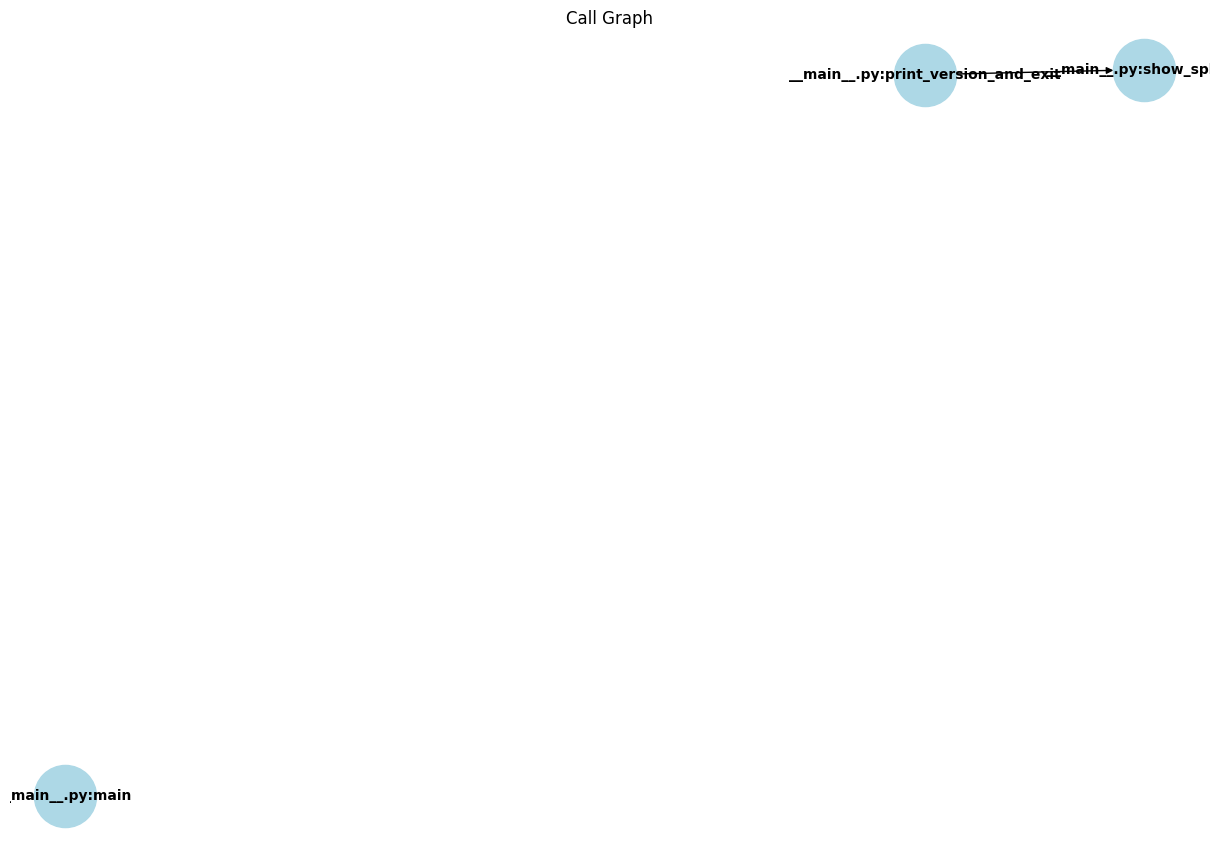

Call graph for ./repos/Python/manim/manim/__main__.py created with 3 nodes and 1 edges.


In [8]:
# ARION CODE
project_path = "./repos/Python/manim/manim/__main__.py"
if os.path.isfile(project_path):
    graph = build_call_graph_from_file(project_path)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
    plt.title("Call Graph")
    plt.show()
    print(f"Call graph for {project_path} created with {len(graph.nodes)} nodes and {len(graph.edges)} edges.")
else:
    print(f"The specified path {project_path} is not a valid file.")

### Own CG older code versions

In [ ]:
# Iterate tree nodes, print if a node is a class or function definition, and also function calls within functions
def print_ast_nodes(node, level=0):
    indent = ' ' * (level * 2)
    
    if isinstance(node, ast.ClassDef):
        print(f"{indent}Class: {node.name}")
    elif isinstance(node, ast.FunctionDef):
        print(f"{indent}Function: {node.name}")
    
    # Ha a node egy függvény, akkor vizsgáljuk a test-jét külön a Call-ok miatt
    if isinstance(node, ast.FunctionDef):
        for stmt in ast.walk(node):
            if isinstance(stmt, ast.Call):
                # Hívott függvény neve (ha tudjuk értelmezni)
                if isinstance(stmt.func, ast.Name):
                    called_func_name = stmt.func.id
                elif isinstance(stmt.func, ast.Attribute):
                    called_func_name = f"{ast.unparse(stmt.func.value)}.{stmt.func.attr}"
                else:
                    called_func_name = ast.unparse(stmt.func)
                print(f"{indent}  Calls: {called_func_name}")
    
    # Rekurzió a gyerekeken
    for child in ast.iter_child_nodes(node):
        print_ast_nodes(child, level + 1)

In [ ]:
def print_ast_nodes(node, level=0):
    indent = ' ' * (level * 2)
    if isinstance(node, ast.ClassDef):
        print(f"{indent}Class: {node.name}")
    elif isinstance(node, ast.FunctionDef):
        print(f"{indent}Function: {node.name}")
    for child in ast.iter_child_nodes(node):
        print_ast_nodes(child, level + 1)

### Print CG

In [ ]:
pcg = PrintCallGraph()
pcg.print_ast_nodes(tree, pcg.build_import_alias_map(tree), pcg.build_instantiation_map(tree))